In [4]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [5]:
XRay_Directory = "chest_xray/train"

In [6]:
os.listdir(XRay_Directory)

['NORMAL', 'PNEUMONIA']

In [7]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation  
image_generator = ImageDataGenerator(rescale = 1./255, validation_split= 0.2)

In [8]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing

train_generator = image_generator.flow_from_directory(batch_size = 40, 
                                                      directory= XRay_Directory,
                                                      shuffle= True,
                                                      target_size=(256,256),
                                                      class_mode = 'categorical',
                                                      subset="training")

Found 4173 images belonging to 2 classes.


In [9]:
validation_generator = image_generator.flow_from_directory(batch_size = 40,
                                                           directory= XRay_Directory,
                                                           shuffle= True,
                                                           target_size=(256,256),
                                                           class_mode = 'categorical',
                                                           subset="validation")

Found 1043 images belonging to 2 classes.


In [10]:
# Generate a batch of 40 images and labels
train_images, train_labels = next(train_generator)

In [11]:
train_images.shape

(40, 256, 256, 3)

In [12]:
train_labels.shape

(40, 2)

In [13]:
train_labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [14]:
# labels Translator 
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

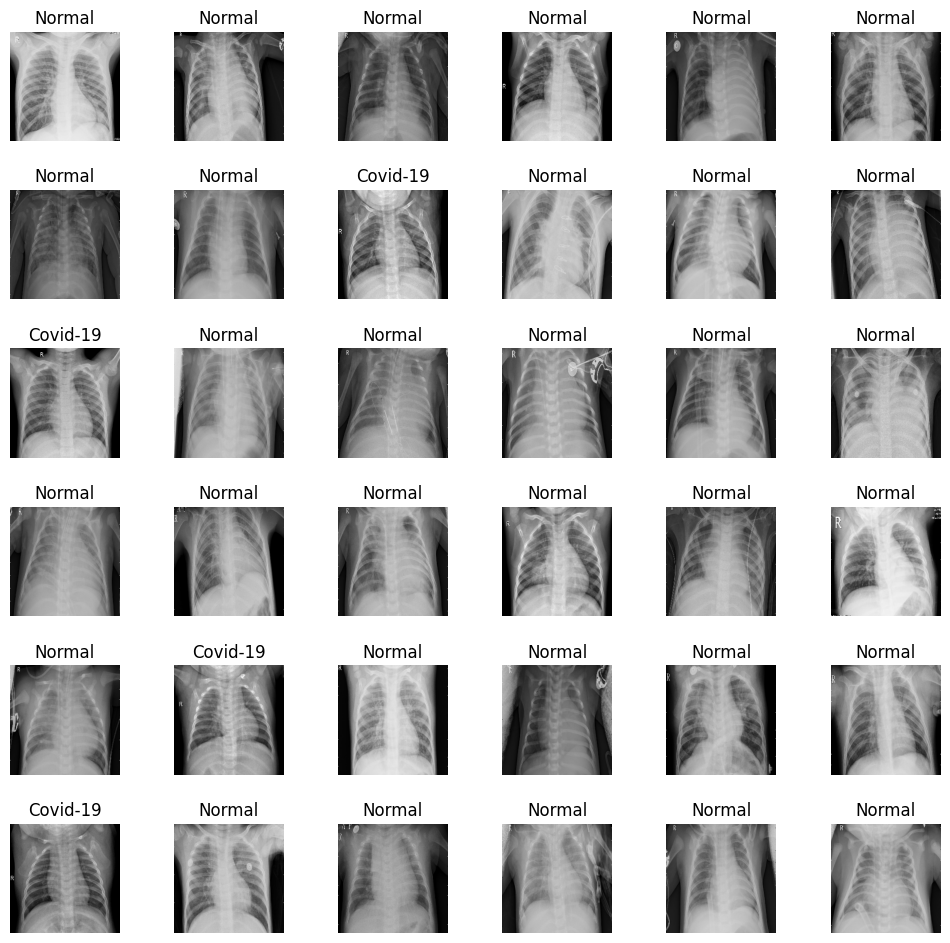

In [15]:
# Create a grid of 36 images along with their corresponding labels
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)    

In [16]:
basemodel = ResNet50(weights = 'imagenet',
                     include_top = False,
                     input_tensor=Input(shape = (256, 256, 3)))

In [17]:
basemodel.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [18]:
#freezing the model upto the last stage - 4 and re-training stage -5 

for layer in basemodel.layers[:-10]:
  layers.trainable = False

In [19]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = "relu")(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)


In [20]:
model = Model(inputs=basemodel.input,
              outputs=headmodel)

In [21]:
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.RMSprop(learning_rate=1e-4, decay=1e-6),
              metrics=['accuracy'])

d:\DS\skeleton_operation\venv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [22]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
check_pointer = ModelCheckpoint(filepath="weights.h5", verbose=1, save_best_only=True)

In [23]:
train_generator = image_generator.flow_from_directory(batch_size = 4, 
                                                      directory= XRay_Directory, 
                                                      shuffle= True, 
                                                      target_size=(256,256), 
                                                      class_mode= 'categorical', 
                                                      subset="training")
val_generator = image_generator.flow_from_directory(batch_size = 4, 
                                                    directory= XRay_Directory, 
                                                    shuffle= True,
                                                    target_size=(256,256), 
                                                    class_mode= 'categorical', 
                                                    subset="validation")

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [24]:
tf.config.optimizer.set_jit(True) 
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import ReduceLROnPlateau

mixed_precision.set_global_policy('mixed_float16')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

history = model.fit(train_generator,
                    epochs=5,
                    validation_data=val_generator,
                    batch_size=16,
                    callbacks= [check_pointer, early_stopping, reduce_lr],
                    )


d:\DS\skeleton_operation\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


d:\DS\skeleton_operation\venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


1044/1044 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9043 - loss: 0.3104
Epoch 1: val_loss improved from inf to 0.18636, saving model to weights.h5


1044/1044 ━━━━━━━━━━━━━━━━━━━━ 2050s 2s/step - accuracy: 0.9043 - loss: 0.3104 - val_accuracy: 0.9262 - val_loss: 0.1864 - learning_rate: 1.0000e-04
Epoch 2/5
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9739 - loss: 0.0958
Epoch 2: val_loss improved from 0.18636 to 0.12213, saving model to weights.h5


1044/1044 ━━━━━━━━━━━━━━━━━━━━ 1953s 2s/step - accuracy: 0.9739 - loss: 0.0958 - val_accuracy: 0.9722 - val_loss: 0.1221 - learning_rate: 1.0000e-04
Epoch 3/5
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9853 - loss: 0.0596
Epoch 3: val_loss improved from 0.12213 to 0.11971, saving model to weights.h5


1044/1044 ━━━━━━━━━━━━━━━━━━━━ 1867s 2s/step - accuracy: 0.9853 - loss: 0.0596 - val_accuracy: 0.9789 - val_loss: 0.1197 - learning_rate: 1.0000e-04
Epoch 4/5
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9895 - loss: 0.0344
Epoch 4: val_loss improved from 0.11971 to 0.09000, saving model to weights.h5


1044/1044 ━━━━━━━━━━━━━━━━━━━━ 1649s 2s/step - accuracy: 0.9895 - loss: 0.0344 - val_accuracy: 0.9818 - val_loss: 0.0900 - learning_rate: 1.0000e-04
Epoch 5/5
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9981 - loss: 0.0087
Epoch 5: val_loss improved from 0.09000 to 0.08905, saving model to weights.h5


1044/1044 ━━━━━━━━━━━━━━━━━━━━ 1979s 2s/step - accuracy: 0.9981 - loss: 0.0087 - val_accuracy: 0.9885 - val_loss: 0.0890 - learning_rate: 1.0000e-04


In [25]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

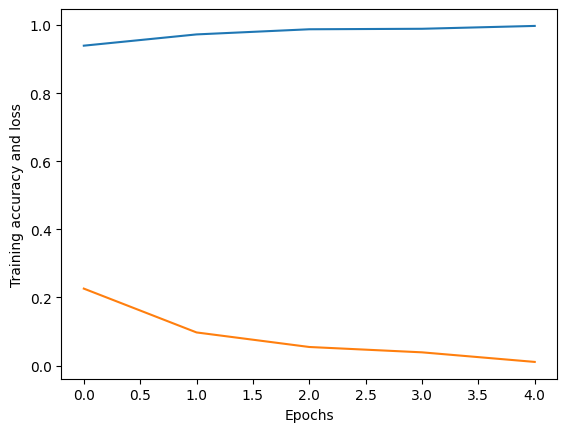

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training accuracy and loss")
plt.show()

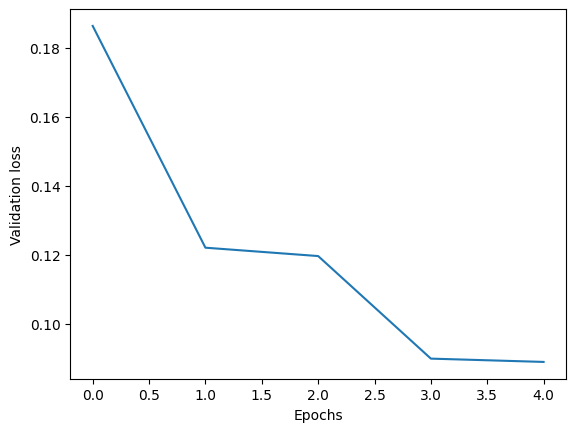

In [27]:
plt.plot(history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Validation loss")
plt.show()

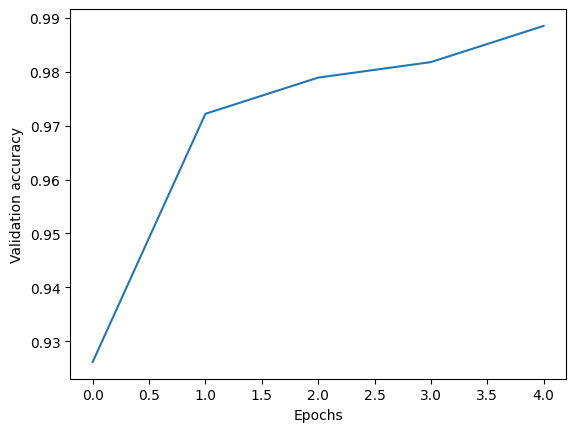

In [28]:
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Validation accuracy")
plt.show()

In [29]:
test_directory = "chest_xray/test"

In [30]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 40, 
                                              directory= test_directory, 
                                              shuffle= True, 
                                              target_size=(256,256), 
                                              class_mode= 'categorical')

evaluate = model.evaluate(test_generator, 
                          steps = test_generator.n // 4, 
                          verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 624 images belonging to 2 classes.
156/156 ━━━━━━━━━━━━━━━━━━━━ 47s 278ms/step - accuracy: 0.7837 - loss: 4.6246
Accuracy Test : 0.7836538553237915


d:\DS\skeleton_operation\venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [31]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

class_labels = sorted(os.listdir(test_directory))  

prediction = []
original = []
image = []

for label in class_labels:
    label_path = os.path.join(test_directory, label)
    
    if not os.path.isdir(label_path):
        continue
    
    for item in os.listdir(label_path):
        img_path = os.path.join(label_path, item)

        img = cv2.imread(img_path)
        if img is None:
            print(f"Error when read images: {img_path}")
            continue
        
        img = cv2.resize(img, (256, 256))
        image.append(img)

        img = img / 255.0
        img = img.reshape(-1, 256, 256, 3)

        predict = model.predict(img)
        predict = np.argmax(predict)

        prediction.append(class_labels[predict])
        original.append(label) 

print("\n🔥 Classification Report:")
print(classification_report(original, prediction, target_names=class_labels))

print("\n🔥 Confusion Matrix:")
print(confusion_matrix(original, prediction, labels=class_labels)) 

print("\n🔥 Accuracy Score:")
print(accuracy_score(original, prediction))


d:\DS\skeleton_operation\venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

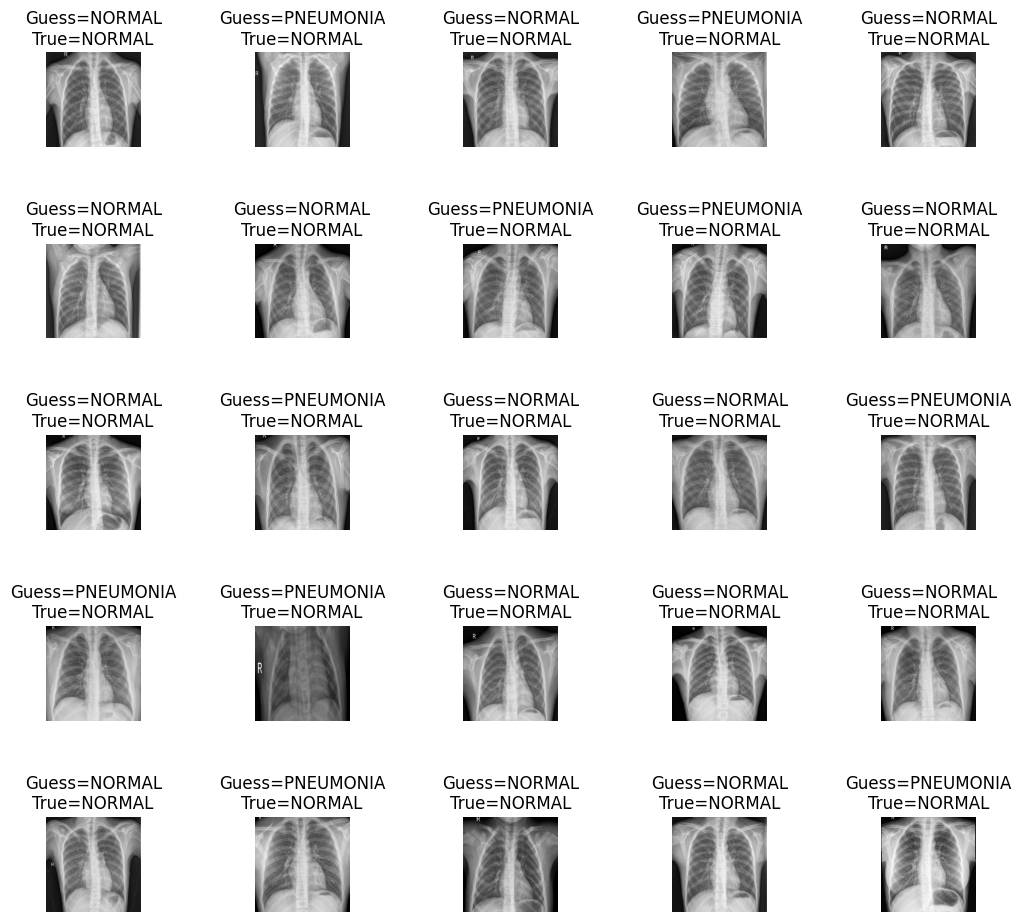

In [32]:
import matplotlib.pyplot as plt
import numpy as np

L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize=(12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])

    axes[i].set_title(f'Guess={prediction[i]}\nTrue={original[i]}')
    axes[i].axis('off')

plt.subplots_adjust(wspace=1.2)
plt.show()


In [33]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

      NORMAL       0.98      0.41      0.57       234
   PNEUMONIA       0.74      0.99      0.85       390

    accuracy                           0.77       624
   macro avg       0.86      0.70      0.71       624
weighted avg       0.83      0.77      0.74       624



Text(0.5, 1.0, 'Confusion_matrix')

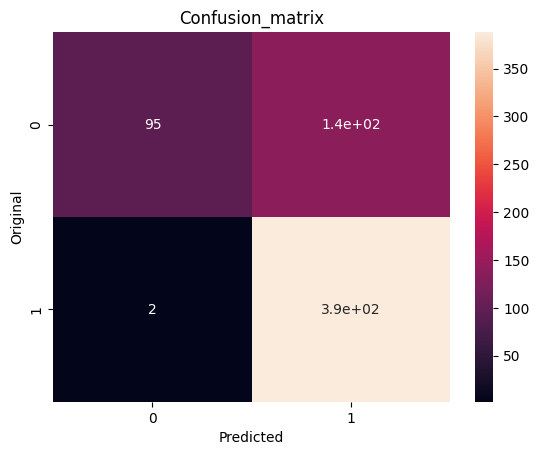

In [34]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')